### **Mini-project n° 2 – Conditional VAEs**
Groupe 5: Vilde , Laura, Chung et Min-Thi

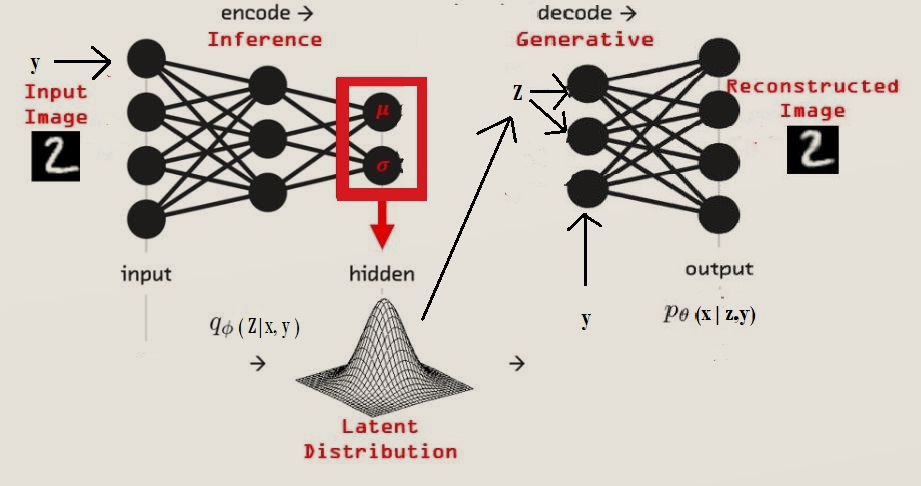



---



# **1. Introduction and theory**

The Conditional Variational Autoencoder (CVAE) was introduced in 2015 by Kingma, D.P., & Welling, M. in the paper "Learning Structured Output Representation" (Sohn, Yan, & Lee, 2015). As the name implies, this variational autoencoder adds conditional information to the latent space, allowing the model to generate outputs based on specific conditions, such as labels or other input features.

By conditioning the latent variable on additional information, the CVAE can model complex data distributions while also generating samples that are conditioned on specific labels.

During the making of the CVAE model in this project notebook we will look furter into how the conditional information works using the FashionMNIST dataset (Zalando Research, n.d.).


## **1.1. The CVAE loss function**

The Conditional Variational Autoencoder (CVAE) loss function is defined as:

$$
\mathcal{L}(x, y; \theta, \phi) = \mathbb{E}_{q_{\phi}(z|x,y)}[\log p_{\theta}(y|x,z)] - \text{KL}(q_{\phi}(z|x,y) \parallel p_{\theta}(z|x))
$$

We will in this notebook use the β-weighted KL divergence to further explore the unfluence of the KL divergence

CVAE loss function ith β-weighted KL divergence:
$$
L(x, y; \theta, \phi) = \mathbb{E}_{q_{\phi}(z|x,y)} \left[ \log p_{\theta}(y|x,z) \right] - \beta \cdot \text{KL} \left( q_{\phi}(z|x,y) \parallel p_{\theta}(z|x) \right)
$$


Where:
- $x$ is the input data,
- $y$ is the conditional target data,
- $q_{\phi}(z|x,y)$ is the encoder (approximate posterior),
- $p_{\theta}(y|x,z)$ is the decoder (likelihood),
- $p_{\theta}(z|x)$ is the prior distribution,
- β controls the weight of the KL divergence term in the loss function.
- and $\text{KL}$ is the Kullback-Leibler divergence.


The Loss function contains two key components: the reconstruction loss and the Kullback-Leibler (KL) divergence.

* The reconstruction loss ensures the accuracy of the outpt "y" form the input "x" and the latent space "z". It ensures that the loss function is sensitive enough.

* The KL Divergence on the other hand ensures that the loss function is insensitive enough. It regularizes the latent space, ensuring that the posterior distribution (the distribution of latent variables learned from the data) is close to the prior distribution (the simple, predefined distribution), preventing overfitting and encouraging generalization. We want the posterior to not stray too far from the prior.

In addition the beta parameter controls the trade-off between reconstruction accuracy and the regularization of the latent space. A higher β places more importance on regularization, while a lower β prioritizes reconstruction.

## **1.2. CVAE vs VAE**


### Loss function

The loss function used in a traditional variational eutoencoder (VAE) is :
$$
L(x; \theta, \phi) = \mathbb{E}_{q_\phi(z|x)}[\log p_\theta(x|z)] - \text{KL}(q_\phi(z|x) \parallel p_\theta(z))
$$

As the name says, and as we have seen the CVAE adds a conditioning on the input.
* In VAE, the loss function is based solely on the input data x, where the encoder $qϕ(z∣x)$ and the decoder $pθ(x∣z)$ are both conditioned on x.
* In CVAE, both the encoder and decoder are conditioned on both the input x **and the additional condition y**. The encoder $qϕ(z∣x,y)$ and the decoder $pθ(x∣z,y)$ take y into account, making the model capable of conditional generation.

### Conditional generation

As mentioned above using a CVAE alows conditional generation. Lets look at the difference this makes whan comparing to a traditional VAE.

* Without conditioning (VAE): The model learns to generate random images based on the overall distribution of all the clothing types, without any control over which specific clothing type is generated.

* With conditioning (CVAE): The model takes a condition (e.g., a label for the clothing type) as an additional input. Now, you can specify the type of clothing you want the model to generate (e.g., "generate a pair of shoes"). The model will then generate data (images) based on the condition you provide.

# **2. Implementing the Conditional Variational Autoencoder (CVAE)**

The following work is based on the practical work done during the HDDL course (in particular the vae notebook) but adding the conditional dimension and additional explorations.

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage
from torchvision.models import inception_v3
from scipy.linalg import sqrtm
import torch.nn.functional as F
from sklearn.decomposition import PCA


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## **2.1. Loading the train and test dataset**

In [ ]:
from torchvision import datasets, transforms
batch_size = 128

# Data loading
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='../../data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='../../data', train=False, transform=transform, download=True)

# Split train_dataset into train and validation sets
val_ratio = 0.1  # 10% of the training data for validation
val_size = int(len(train_dataset) * val_ratio)
train_size = len(train_dataset) - val_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Lets now look at the sizes of the datasets and the size of the images.

In [ ]:
test_size = len(test_dataset)

print(f"Training set size: {train_size}")
print(f"Validation set size: {train_size}")
print(f"Test set size: {test_size}")
print(f"Image shape: {train_dataset[0][0].shape}")

Training set size: 54000
Validation set size: 54000
Test set size: 10000
Image shape: torch.Size([1, 28, 28])


The names of the classes is the FashionMnist data set are the following:

In [ ]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

Lets now look at the distibution of data in each class of the dataset.


Class distribution in the training dataset:

Class Distribution (Training Data)
T-shirt/top: 5448 images
Trouser: 5408 images
Pullover: 5373 images
Dress: 5428 images
Coat: 5370 images
Sandal: 5404 images
Shirt: 5341 images
Sneaker: 5422 images
Bag: 5393 images
Ankle boot: 5413 images


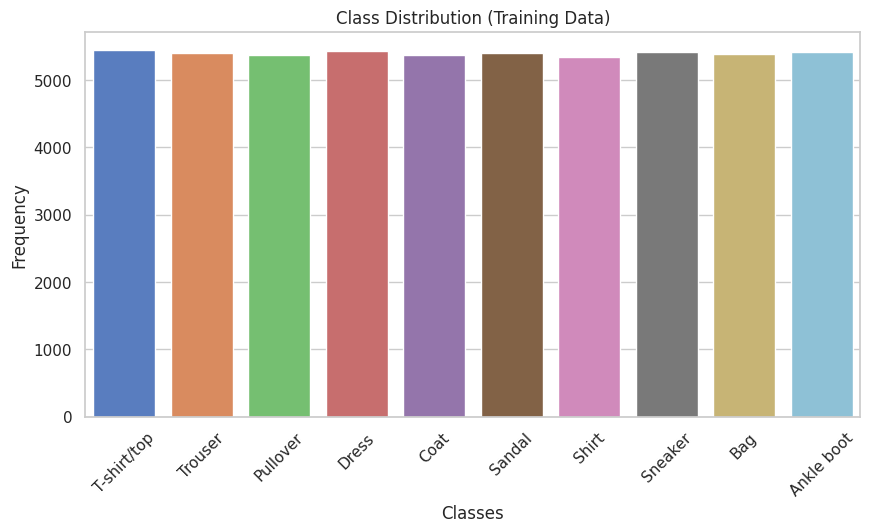


Class distribution in the validation dataset:

Class Distribution (Validation Data)
T-shirt/top: 552 images
Trouser: 592 images
Pullover: 627 images
Dress: 572 images
Coat: 630 images
Sandal: 596 images
Shirt: 659 images
Sneaker: 578 images
Bag: 607 images
Ankle boot: 587 images


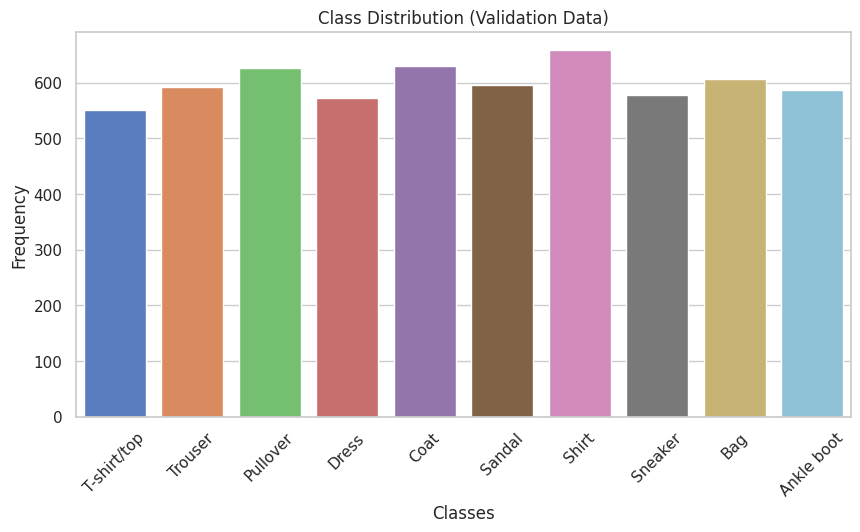


Class distribution in the test dataset:

Class Distribution (Test Data)
T-shirt/top: 1000 images
Trouser: 1000 images
Pullover: 1000 images
Dress: 1000 images
Coat: 1000 images
Sandal: 1000 images
Shirt: 1000 images
Sneaker: 1000 images
Bag: 1000 images
Ankle boot: 1000 images


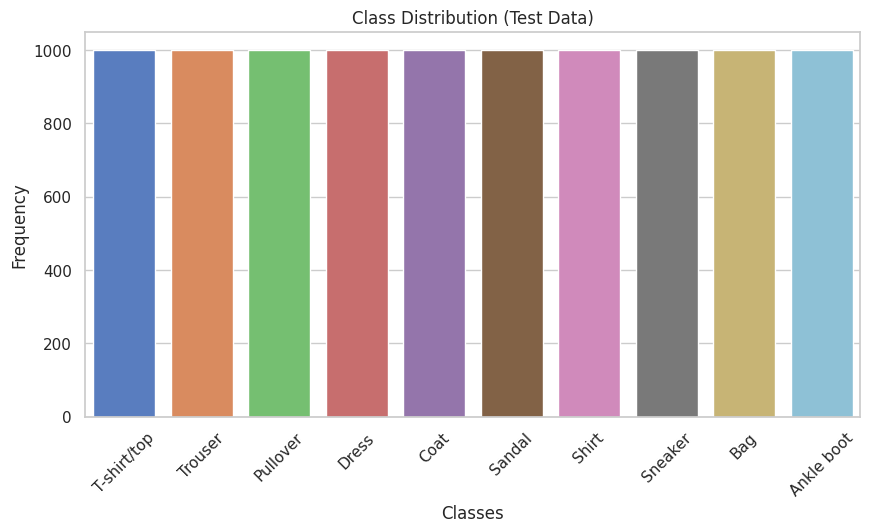

In [ ]:
import seaborn as sns
def plot_class_distribution(dataset, class_names, title):
    labels = [label for _, label in dataset]
    class_counts = {class_name: labels.count(idx) for idx, class_name in enumerate(class_names)}

    print(f"\n{title}")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count} images")

    # Plot
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 5))
    sns.countplot(x=labels, hue=labels, palette="muted", order=np.arange(len(class_names)), dodge=False, legend=False)
    plt.title(title)
    plt.xlabel("Classes")
    plt.ylabel("Frequency")
    plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=45)
    plt.show()

print("\nClass distribution in the training dataset:")
plot_class_distribution(train_dataset, class_names, "Class Distribution (Training Data)")

print("\nClass distribution in the validation dataset:")
plot_class_distribution(val_dataset, class_names, "Class Distribution (Validation Data)")

print("\nClass distribution in the test dataset:")
plot_class_distribution(test_dataset, class_names, "Class Distribution (Test Data)")

We can see that we are working with a well-rounded dataset (equal amount of data in each class), and we do not need to modify our dataset in any way. Let's now visualize the dataset.

## **2.2. Visualizing a Batch of Fashion-MNIST Images**

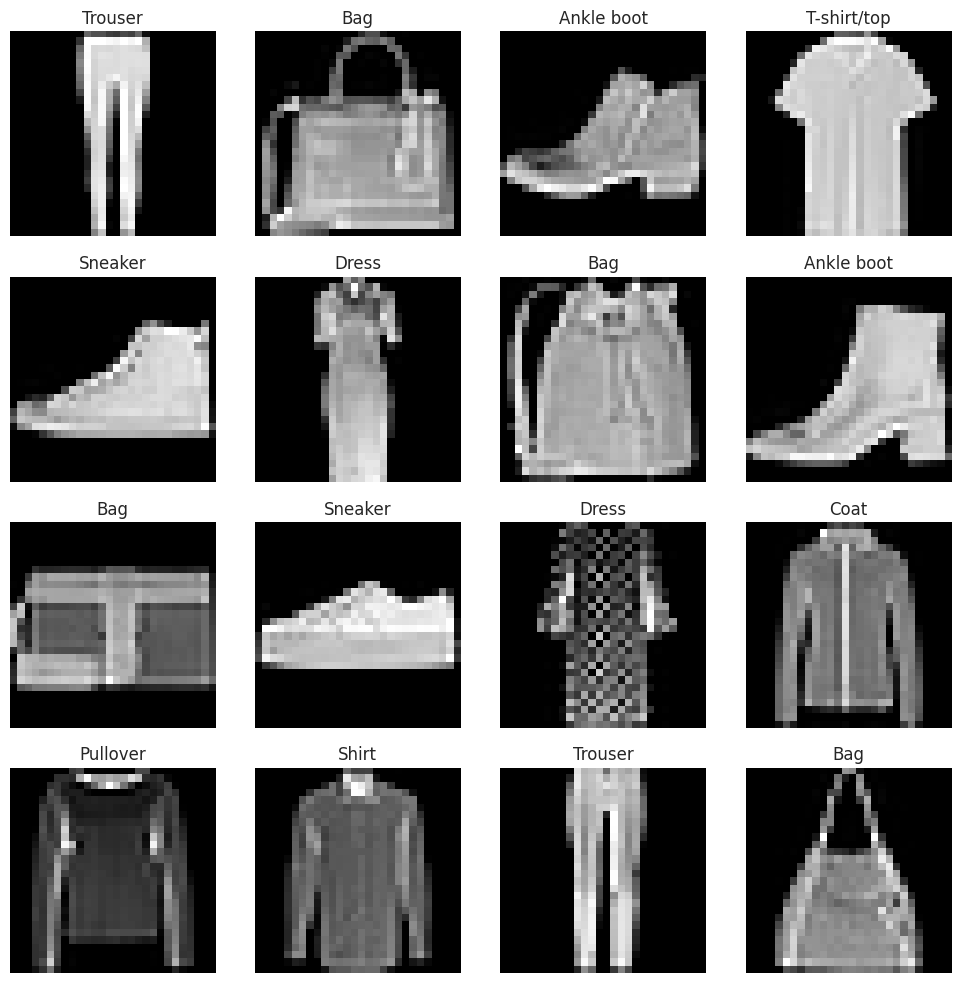

In [ ]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Get one batch of images and labels
images, labels = next(iter(train_loader))

# Plot the batch of images
plt.figure(figsize=(10, 10))
for i in range(batch_size):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.title(class_names[labels[i]])
    plt.axis("off")

plt.tight_layout()
plt.show()

We observe that the images are relatively low in quality, but in this project, our CVAE model will be able to learn structured latent representations and generate new images conditioned on labels.

## **2.3. The CVAE model**

### The encoder:

* Consist of three convolutional layers from which it learns features. Each convolutional layer reduces the dimensions of the input image while increasing the depth of the feature maps.

* After each convolutional layer we do a batch normalization. The batch normalization normalizes the inputs to each layer, ensuring that they have a consistent mean and variance across batches.

* The ReLU activation function is used throughout the encoder and decoder. This function helps avoid the vanishing gradient problem and facilitates easier computations by setting negative values to zero, there by deactivating those neurons.

### Fully Connected Layers for Latent Space
 * After the convolutional layers, the model flattens the feature map into a vector of size 128 * 4 * 4 (i.e., a flattened 128-channel 4x4 feature map). This vector is concatenated with the condition vector (the class label, one-hot encoded) to create the input for the fully connected layers. This conditioning allows the model to generate class-specific samples during decoding.

 * The network outputs two values: the mean (fc_mu) and the log variance (fc_logvar). The encoder takes in the input data and its associated condition (label) to generate the values. These mean and log variance values define a Gaussian distribution, from which we sample the latent vector z during training, using the parameterization trick.



### The decoder:

Like the encoder, the decoder also implement batch normalization, and uses the ReLU activation function. However, there are some important differences:

* The decoder uses ConvTranspose2d (deconvolutional layers) instead of Conv2d (convolution layers). The deconvolution layers increase the spatial dimensions instead of reducing them, which allows us to rebuild a reconstructed image from the latent representation.

* For the last layer of the decoder, a Sigmoid activation function is used to produce pixel values between 0 and 1 for the output image.  

In [ ]:
class CVAE(nn.Module):
    def __init__(self, latent_dim=10, condition_dim=10 ):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.condition_dim = condition_dim #ADDED

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 14, 14)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 7, 7)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Output: (128, 4, 4)
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Fully connected layers for mean and log variance, ADDING the conditional dimension to the input
        self.fc_mu = nn.Linear(128 * 4 * 4 + condition_dim, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4 + condition_dim, latent_dim)
        self.fc_decode = nn.Linear(latent_dim + condition_dim, 128 * 4 * 4)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 8, 8)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 16, 16)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # Output: (1, 28, 28)
            nn.Sigmoid()
        )


    def encode(self, x, c ): # q(z|x, c)
        x = self.encoder(x)
        """ print("encode")
        print(np.shape(x))
        print(np.shape(c))  """
        x = x.view(-1, 128 * 4 * 4) # Flatten the output of the convolutional layers

        x = torch.cat([x, c], dim=1) # ADDED

        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c ): # p(x|z, c)
        """ print("decode")
        print(np.shape(z))
        print(np.shape(c)) """
        z = torch.cat([z, c], dim=1) # ADDED

        x = self.fc_decode(z)
        x = x.view(-1, 128, 4, 4)
        x = self.decoder(x)
        return x

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.sample(mu, logvar)
        return self.decode(z, c), mu, logvar

# **3. Train the CVAE**

## **3.1. CVAE loss function**

In [ ]:
# Implement the loss function
def loss_function_cvae(recon_x, x, mu, logvar, beta=1):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD, BCE, KLD

## **3.2. Hyperparameter Tuning**

To train the CVAE model, we need to find the best set of hyperparameters. To do this, we'll use grid search to try out different combinations of hyperparameters to explore the possibilities. After we have trained the model with each combination, we'll evaluate its performance on the validation set and pick the hyperparameters that result in the lowest val loss. This approach makes sure that we are choosing the optimal configuration for the model.

Total hyperparameter combinations: 18

Testing combination 1/18:
latent_dim=10, condition_dim=10, learning_rate=0.001, beta=0.5, epochs=5
Epoch [1/5], Recon Loss: 236.5142, KL Loss: 17.9957, Total Loss: 245.5121
Epoch [2/5], Recon Loss: 226.1278, KL Loss: 17.8545, Total Loss: 235.0551
Epoch [3/5], Recon Loss: 223.9433, KL Loss: 17.7590, Total Loss: 232.8229
Epoch [4/5], Recon Loss: 222.6098, KL Loss: 17.6659, Total Loss: 231.4427
Epoch [5/5], Recon Loss: 221.7813, KL Loss: 17.5904, Total Loss: 230.5765


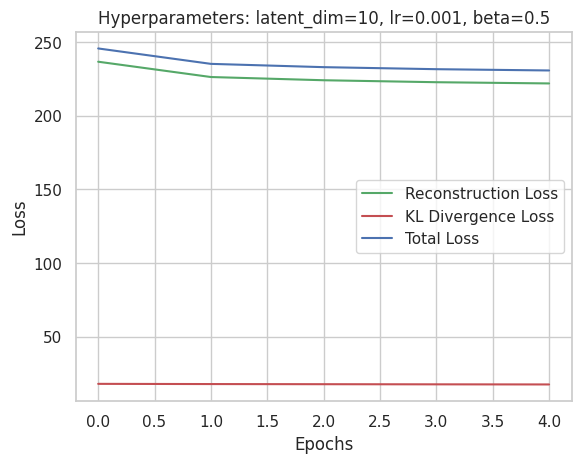


Testing combination 2/18:
latent_dim=10, condition_dim=10, learning_rate=0.001, beta=1, epochs=5
Epoch [1/5], Recon Loss: 240.0638, KL Loss: 12.8680, Total Loss: 252.9319
Epoch [2/5], Recon Loss: 230.3145, KL Loss: 12.7969, Total Loss: 243.1113
Epoch [3/5], Recon Loss: 227.9587, KL Loss: 12.7000, Total Loss: 240.6587
Epoch [4/5], Recon Loss: 226.5864, KL Loss: 12.6354, Total Loss: 239.2218
Epoch [5/5], Recon Loss: 225.6367, KL Loss: 12.6529, Total Loss: 238.2896


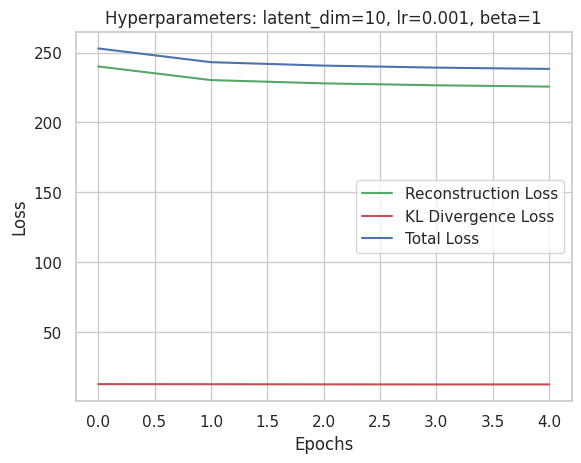


Testing combination 3/18:
latent_dim=10, condition_dim=10, learning_rate=0.001, beta=2, epochs=5
Epoch [1/5], Recon Loss: 249.9249, KL Loss: 7.9246, Total Loss: 265.7741
Epoch [2/5], Recon Loss: 237.8390, KL Loss: 7.8554, Total Loss: 253.5499
Epoch [3/5], Recon Loss: 235.1098, KL Loss: 7.9146, Total Loss: 250.9389
Epoch [4/5], Recon Loss: 233.6088, KL Loss: 7.9320, Total Loss: 249.4728
Epoch [5/5], Recon Loss: 232.7131, KL Loss: 7.9558, Total Loss: 248.6247


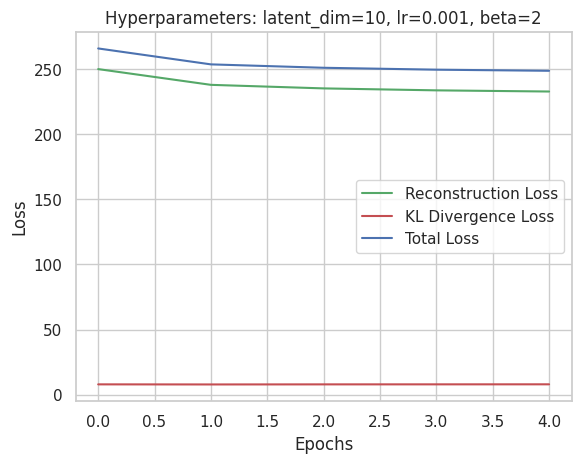


Testing combination 4/18:
latent_dim=10, condition_dim=10, learning_rate=0.0001, beta=0.5, epochs=5
Epoch [1/5], Recon Loss: 255.3908, KL Loss: 18.3788, Total Loss: 264.5802
Epoch [2/5], Recon Loss: 229.1447, KL Loss: 18.9101, Total Loss: 238.5998
Epoch [3/5], Recon Loss: 226.1316, KL Loss: 19.0090, Total Loss: 235.6361
Epoch [4/5], Recon Loss: 224.6272, KL Loss: 18.9646, Total Loss: 234.1095
Epoch [5/5], Recon Loss: 223.6428, KL Loss: 18.9077, Total Loss: 233.0966


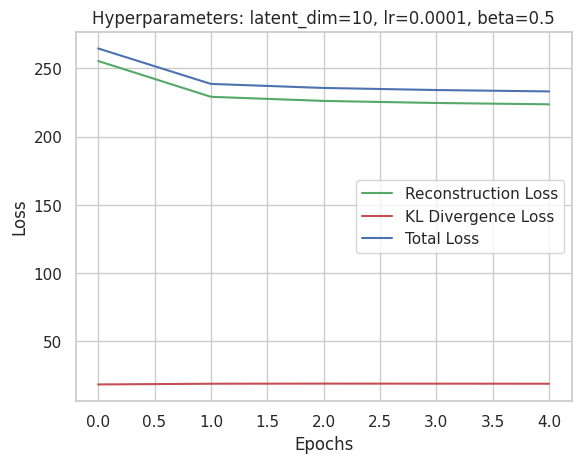


Testing combination 5/18:
latent_dim=10, condition_dim=10, learning_rate=0.0001, beta=1, epochs=5
Epoch [1/5], Recon Loss: 265.8569, KL Loss: 13.3276, Total Loss: 279.1845
Epoch [2/5], Recon Loss: 233.5214, KL Loss: 13.7046, Total Loss: 247.2260
Epoch [3/5], Recon Loss: 230.4163, KL Loss: 13.7177, Total Loss: 244.1340
Epoch [4/5], Recon Loss: 228.8472, KL Loss: 13.6732, Total Loss: 242.5205
Epoch [5/5], Recon Loss: 227.8806, KL Loss: 13.6528, Total Loss: 241.5334


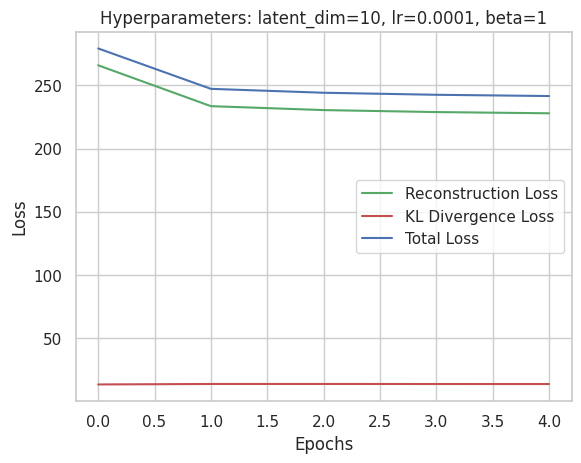


Testing combination 6/18:
latent_dim=10, condition_dim=10, learning_rate=0.0001, beta=2, epochs=5
Epoch [1/5], Recon Loss: 266.7276, KL Loss: 8.6102, Total Loss: 283.9481
Epoch [2/5], Recon Loss: 240.9581, KL Loss: 8.7143, Total Loss: 258.3867
Epoch [3/5], Recon Loss: 237.8813, KL Loss: 8.7028, Total Loss: 255.2868
Epoch [4/5], Recon Loss: 236.2242, KL Loss: 8.6420, Total Loss: 253.5083
Epoch [5/5], Recon Loss: 235.1196, KL Loss: 8.5796, Total Loss: 252.2788


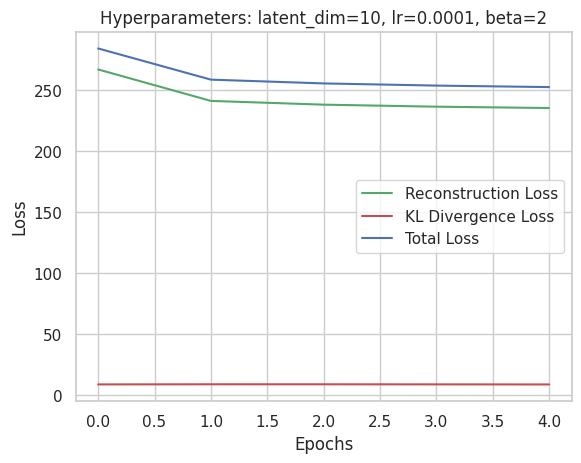


Testing combination 7/18:
latent_dim=20, condition_dim=10, learning_rate=0.001, beta=0.5, epochs=5
Epoch [1/5], Recon Loss: 233.5515, KL Loss: 23.3454, Total Loss: 245.2242
Epoch [2/5], Recon Loss: 222.9177, KL Loss: 22.9526, Total Loss: 234.3940
Epoch [3/5], Recon Loss: 220.5885, KL Loss: 22.8013, Total Loss: 231.9892
Epoch [4/5], Recon Loss: 219.3030, KL Loss: 22.6010, Total Loss: 230.6035
Epoch [5/5], Recon Loss: 218.4775, KL Loss: 22.4891, Total Loss: 229.7220


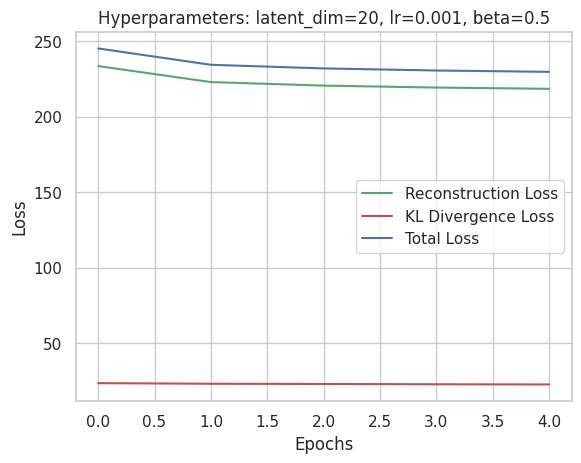


Testing combination 8/18:
latent_dim=20, condition_dim=10, learning_rate=0.001, beta=1, epochs=5
Epoch [1/5], Recon Loss: 240.6575, KL Loss: 14.5679, Total Loss: 255.2254
Epoch [2/5], Recon Loss: 229.4524, KL Loss: 14.1161, Total Loss: 243.5685
Epoch [3/5], Recon Loss: 227.0403, KL Loss: 13.9807, Total Loss: 241.0210
Epoch [4/5], Recon Loss: 225.5840, KL Loss: 13.9414, Total Loss: 239.5254
Epoch [5/5], Recon Loss: 224.7025, KL Loss: 13.9012, Total Loss: 238.6036


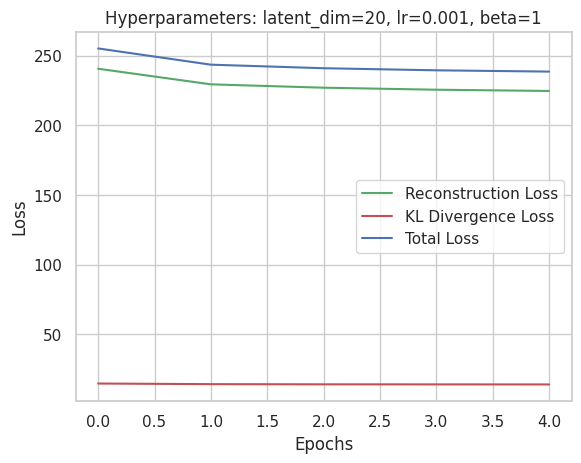


Testing combination 9/18:
latent_dim=20, condition_dim=10, learning_rate=0.001, beta=2, epochs=5
Epoch [1/5], Recon Loss: 249.9125, KL Loss: 8.3371, Total Loss: 266.5868
Epoch [2/5], Recon Loss: 238.5332, KL Loss: 7.9259, Total Loss: 254.3850
Epoch [3/5], Recon Loss: 235.7008, KL Loss: 7.9222, Total Loss: 251.5451
Epoch [4/5], Recon Loss: 234.1076, KL Loss: 7.9643, Total Loss: 250.0361
Epoch [5/5], Recon Loss: 233.0200, KL Loss: 7.9918, Total Loss: 249.0036


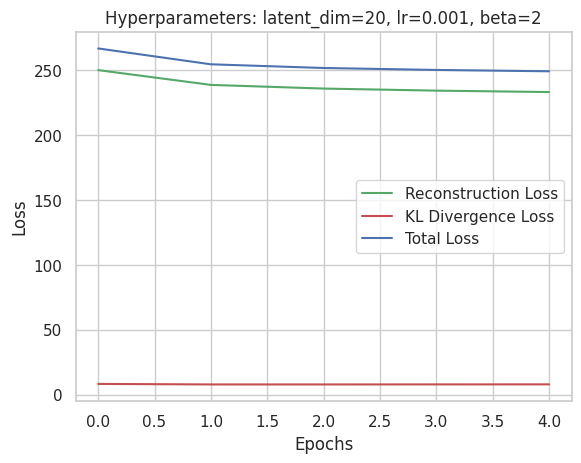


Testing combination 10/18:
latent_dim=20, condition_dim=10, learning_rate=0.0001, beta=0.5, epochs=5
Epoch [1/5], Recon Loss: 253.0289, KL Loss: 25.3654, Total Loss: 265.7116
Epoch [2/5], Recon Loss: 226.3082, KL Loss: 25.3977, Total Loss: 239.0070
Epoch [3/5], Recon Loss: 223.0907, KL Loss: 25.1025, Total Loss: 235.6419
Epoch [4/5], Recon Loss: 221.5881, KL Loss: 24.9022, Total Loss: 234.0392
Epoch [5/5], Recon Loss: 220.5860, KL Loss: 24.7347, Total Loss: 232.9533


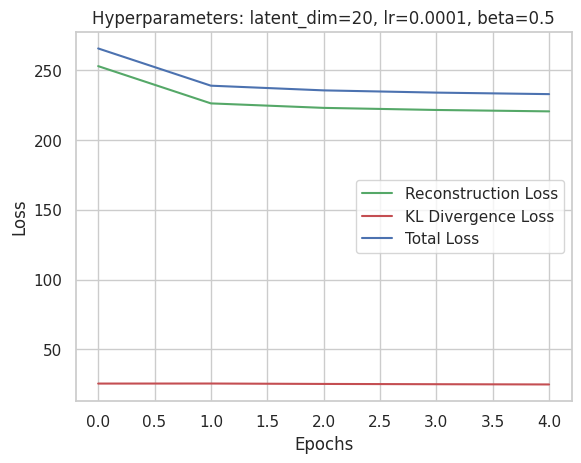


Testing combination 11/18:
latent_dim=20, condition_dim=10, learning_rate=0.0001, beta=1, epochs=5
Epoch [1/5], Recon Loss: 258.2095, KL Loss: 16.2735, Total Loss: 274.4830
Epoch [2/5], Recon Loss: 233.2230, KL Loss: 15.8179, Total Loss: 249.0409
Epoch [3/5], Recon Loss: 229.9115, KL Loss: 15.5908, Total Loss: 245.5023
Epoch [4/5], Recon Loss: 228.2435, KL Loss: 15.4089, Total Loss: 243.6524
Epoch [5/5], Recon Loss: 227.1409, KL Loss: 15.2743, Total Loss: 242.4152


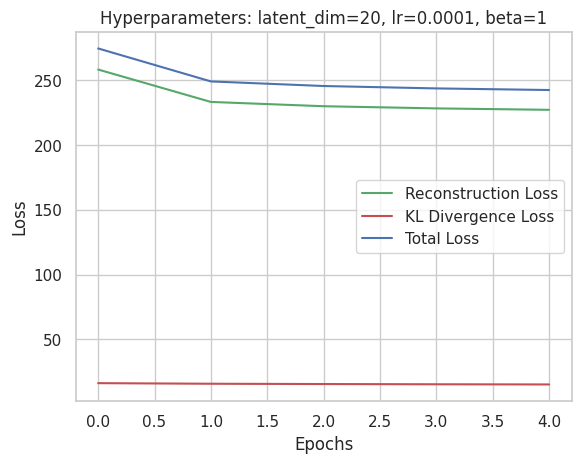


Testing combination 12/18:
latent_dim=20, condition_dim=10, learning_rate=0.0001, beta=2, epochs=5
Epoch [1/5], Recon Loss: 266.7732, KL Loss: 9.3263, Total Loss: 285.4258
Epoch [2/5], Recon Loss: 242.7818, KL Loss: 9.0752, Total Loss: 260.9322
Epoch [3/5], Recon Loss: 239.2373, KL Loss: 9.0296, Total Loss: 257.2965
Epoch [4/5], Recon Loss: 237.3843, KL Loss: 8.9537, Total Loss: 255.2917
Epoch [5/5], Recon Loss: 236.1463, KL Loss: 8.8681, Total Loss: 253.8824


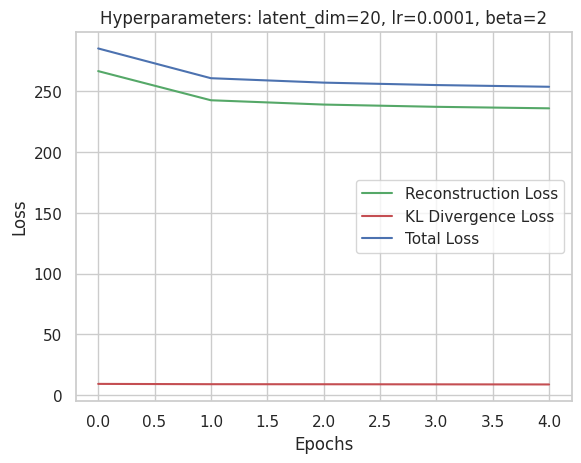


Testing combination 13/18:
latent_dim=30, condition_dim=10, learning_rate=0.001, beta=0.5, epochs=5
Epoch [1/5], Recon Loss: 233.2626, KL Loss: 24.6316, Total Loss: 245.5784
Epoch [2/5], Recon Loss: 222.5975, KL Loss: 24.1879, Total Loss: 234.6915
Epoch [3/5], Recon Loss: 220.3863, KL Loss: 23.8936, Total Loss: 232.3331
Epoch [4/5], Recon Loss: 219.0938, KL Loss: 23.6682, Total Loss: 230.9279
Epoch [5/5], Recon Loss: 218.2823, KL Loss: 23.4269, Total Loss: 229.9958


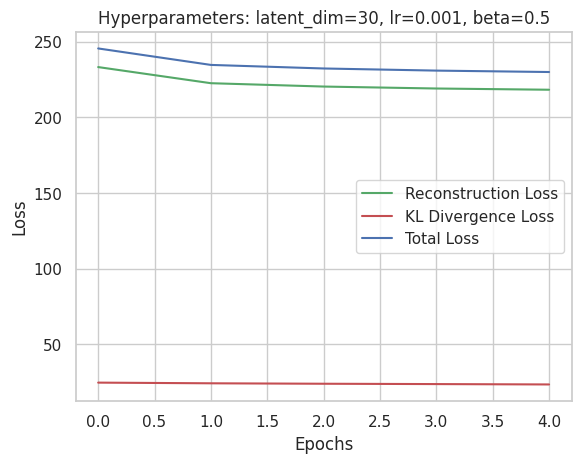


Testing combination 14/18:
latent_dim=30, condition_dim=10, learning_rate=0.001, beta=1, epochs=5
Epoch [1/5], Recon Loss: 241.0093, KL Loss: 14.5188, Total Loss: 255.5281
Epoch [2/5], Recon Loss: 230.0363, KL Loss: 14.0078, Total Loss: 244.0440
Epoch [3/5], Recon Loss: 227.5606, KL Loss: 13.8689, Total Loss: 241.4295
Epoch [4/5], Recon Loss: 226.0278, KL Loss: 13.7793, Total Loss: 239.8071
Epoch [5/5], Recon Loss: 225.0896, KL Loss: 13.7040, Total Loss: 238.7935


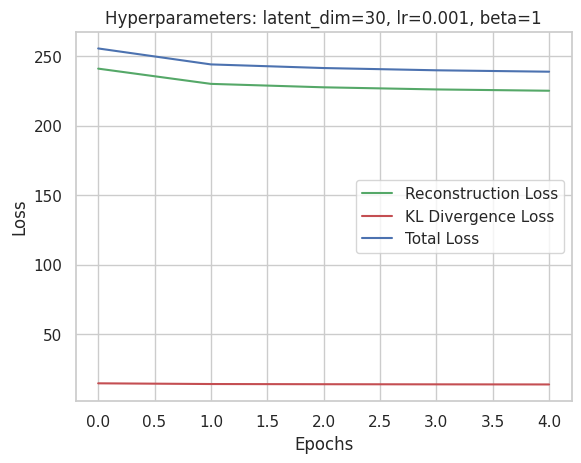


Testing combination 15/18:
latent_dim=30, condition_dim=10, learning_rate=0.001, beta=2, epochs=5
Epoch [1/5], Recon Loss: 250.5166, KL Loss: 8.4803, Total Loss: 267.4772
Epoch [2/5], Recon Loss: 238.9334, KL Loss: 8.0024, Total Loss: 254.9383
Epoch [3/5], Recon Loss: 236.0703, KL Loss: 8.0317, Total Loss: 252.1338
Epoch [4/5], Recon Loss: 234.4651, KL Loss: 8.0725, Total Loss: 250.6101
Epoch [5/5], Recon Loss: 233.3765, KL Loss: 8.1081, Total Loss: 249.5927


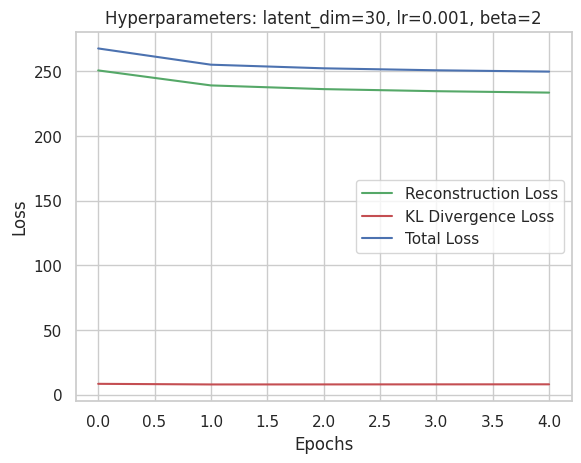


Testing combination 16/18:
latent_dim=30, condition_dim=10, learning_rate=0.0001, beta=0.5, epochs=5
Epoch [1/5], Recon Loss: 247.0971, KL Loss: 28.3174, Total Loss: 261.2558
Epoch [2/5], Recon Loss: 226.2248, KL Loss: 27.4874, Total Loss: 239.9685
Epoch [3/5], Recon Loss: 223.0472, KL Loss: 26.9677, Total Loss: 236.5311
Epoch [4/5], Recon Loss: 221.4640, KL Loss: 26.6178, Total Loss: 234.7729
Epoch [5/5], Recon Loss: 220.3986, KL Loss: 26.3159, Total Loss: 233.5566


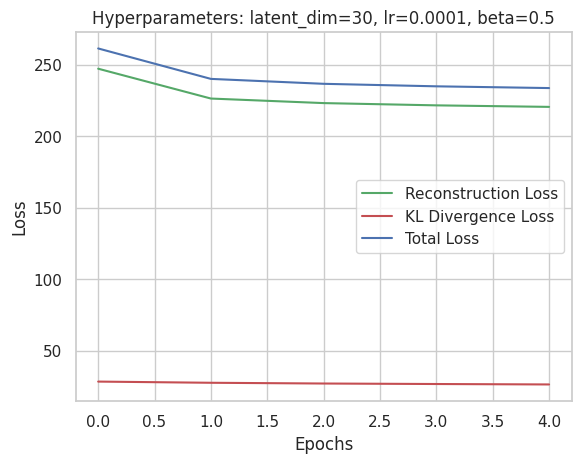


Testing combination 17/18:
latent_dim=30, condition_dim=10, learning_rate=0.0001, beta=1, epochs=5
Epoch [1/5], Recon Loss: 260.9017, KL Loss: 16.9426, Total Loss: 277.8443
Epoch [2/5], Recon Loss: 234.1101, KL Loss: 16.1793, Total Loss: 250.2894
Epoch [3/5], Recon Loss: 230.4752, KL Loss: 16.0486, Total Loss: 246.5237
Epoch [4/5], Recon Loss: 228.6399, KL Loss: 15.9176, Total Loss: 244.5575
Epoch [5/5], Recon Loss: 227.4271, KL Loss: 15.8036, Total Loss: 243.2307


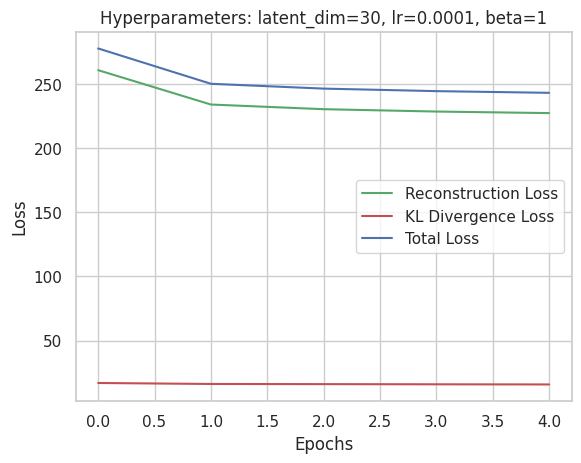


Testing combination 18/18:
latent_dim=30, condition_dim=10, learning_rate=0.0001, beta=2, epochs=5
Epoch [1/5], Recon Loss: 272.7115, KL Loss: 9.3836, Total Loss: 291.4788
Epoch [2/5], Recon Loss: 244.1304, KL Loss: 8.9891, Total Loss: 262.1085
Epoch [3/5], Recon Loss: 240.2727, KL Loss: 8.9220, Total Loss: 258.1166
Epoch [4/5], Recon Loss: 238.2889, KL Loss: 8.8355, Total Loss: 255.9600
Epoch [5/5], Recon Loss: 236.9498, KL Loss: 8.7407, Total Loss: 254.4311


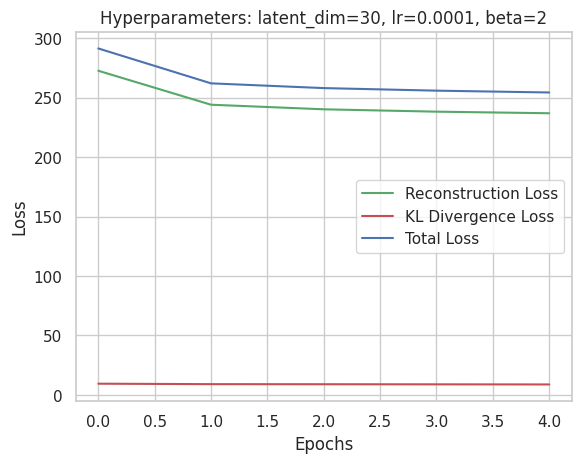


Grid Search Complete!
Best Hyperparameters: {'latent_dim': 20, 'condition_dim': 10, 'learning_rate': 0.001, 'beta': 0.5, 'epochs': 5}
Lowest Validation Loss: 230.9718


In [ ]:
import itertools
import pickle

# Hyperparameters
param_grid = {
    'latent_dim': [10, 20, 30],
    'learning_rate': [1e-3, 1e-4],
    'beta': [0.5, 1, 2],  # weight for KL divergence
}

batch_size = 128
epochs = 5  # Reduced epochs for faster testing
condition_dim = 10  # Number of classes (10 for Fashion-MNIST)

# Generate all combinations of hyperparameters
param_combinations = list(itertools.product(*param_grid.values()))
best_params = None
lowest_val_loss = float('inf')

print(f"Total hyperparameter combinations: {len(param_combinations)}")

for idx, params in enumerate(param_combinations):
    latent_dim, learning_rate, beta = params
    print(f"\nTesting combination {idx + 1}/{len(param_combinations)}:")
    print(f"latent_dim={latent_dim}, condition_dim={condition_dim}, learning_rate={learning_rate}, beta={beta}, epochs={epochs}")

    # Initialize the CVAE model and optimizer
    cvae = CVAE(latent_dim=latent_dim, condition_dim=condition_dim).to(device)
    optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)

    reconstruction_losses = []
    kl_losses = []
    total_losses = []

    for epoch in range(1, epochs + 1):
        cvae.train()
        epoch_recon_loss = 0.0
        epoch_kl_loss = 0.0
        epoch_total_loss = 0.0

        for batch_idx, (data, labels) in enumerate(train_loader):
            data = data.to(device)
            labels = labels.to(device)
            c = F.one_hot(labels, num_classes=condition_dim).float()

            optimizer.zero_grad()
            recon_batch, mu, logvar = cvae(data, c)
            total_loss, recon_loss, kl_loss = loss_function_cvae(recon_batch, data, mu, logvar, beta)
            total_loss.backward()
            optimizer.step()

            # losses
            epoch_recon_loss += recon_loss.item()
            epoch_kl_loss += kl_loss.item()
            epoch_total_loss += total_loss.item()

        reconstruction_losses.append(epoch_recon_loss / len(train_loader.dataset))
        kl_losses.append(epoch_kl_loss / len(train_loader.dataset))
        total_losses.append(epoch_total_loss / len(train_loader.dataset))

        print(f"Epoch [{epoch}/{epochs}], Recon Loss: {epoch_recon_loss / len(train_loader.dataset):.4f}, KL Loss: {epoch_kl_loss / len(train_loader.dataset):.4f}, Total Loss: {epoch_total_loss / len(train_loader.dataset):.4f}")

    # Validation Phase
    cvae.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data, labels in val_loader:
            data = data.to(device)
            labels = labels.to(device)
            c = F.one_hot(labels, num_classes=condition_dim).float()

            recon_batch, mu, logvar = cvae(data, c)
            loss, _, _ = loss_function_cvae(recon_batch, data, mu, logvar, beta)
            val_loss += loss.item()

    val_loss /= len(val_loader.dataset)

    # Save model if it's the best so far
    if val_loss < lowest_val_loss:
        lowest_val_loss = val_loss
        best_params = {
            'latent_dim': latent_dim,
            'condition_dim': condition_dim,
            'learning_rate': learning_rate,
            'beta': beta,
            'epochs': epochs,
        }
        torch.save({
            'model_state_dict': cvae.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'params': best_params,
        },  'best_model_beta.pth')

    # Save training losses
    results = {
        'reconstruction_losses': reconstruction_losses,
        'kl_losses': kl_losses,
        'total_losses': total_losses,
        'val_loss': val_loss,
    }

    file_name = f'training_results_ld_{latent_dim}_lr_{learning_rate}_beta_{beta}.pkl'

    with open(file_name, 'wb') as f:
        pickle.dump(results, f)

    # Plot losses
    plt.plot(reconstruction_losses, label="Reconstruction Loss", color='g')
    plt.plot(kl_losses, label="KL Divergence Loss", color='r')
    plt.plot(total_losses, label="Total Loss", color='b')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Hyperparameters: latent_dim={latent_dim}, lr={learning_rate}, beta={beta}")
    plt.legend()
    plt.show()

print("\nGrid Search Complete!")
print(f"Best Hyperparameters: {best_params}")
print(f"Lowest Validation Loss: {lowest_val_loss:.4f}")

<Figure size 1200x600 with 0 Axes>

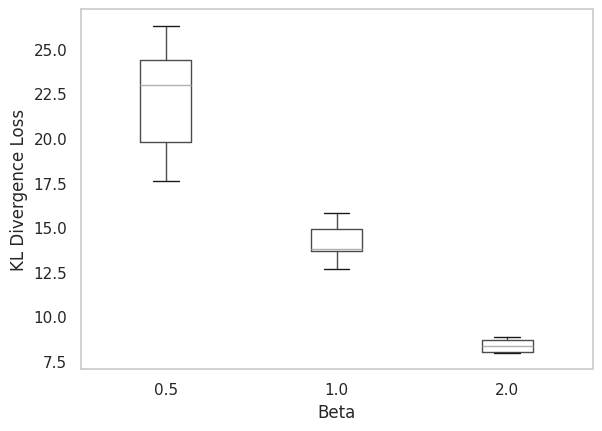

In [ ]:
import os
import pandas as pd

folder_path = "./results"

data = []
for file_name in os.listdir(folder_path):
    if file_name.startswith("training_results") and file_name.endswith(".pkl"):
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, "rb") as f:
            results = pickle.load(f)

        # Extract hyperparameters from the file name
        file_info = file_name.replace(".pkl", "").split("_")
        latent_dim = int(file_info[3])
        learning_rate = float(file_info[5])
        beta = float(file_info[7])

        # Extract the final loss values
        final_recon_loss = results["reconstruction_losses"][-1]
        final_kl_loss = results["kl_losses"][-1]
        final_total_loss = results["total_losses"][-1]

        data.append({
            "latent_dim": latent_dim,
            "learning_rate": learning_rate,
            "beta": beta,
            "final_recon_loss": final_recon_loss,
            "final_kl_loss": final_kl_loss,
            "final_total_loss": final_total_loss,
        })

df = pd.DataFrame(data)

# Boxplot for Beta vs. KL Divergence Loss
plt.figure(figsize=(12, 6))
df.boxplot(column="final_kl_loss", by="beta", grid=False)
plt.title("")
plt.xlabel("Beta")
plt.ylabel("KL Divergence Loss")
plt.suptitle("")
plt.show()

High values of $\beta$ in a Variational Autoencoder (VAE) or $\beta$-VAE decrease the KL Divergence (KLD) error because $\beta $ scales the KL divergence term in the loss function:

$$
\mathcal{L} = \text{Reconstruction Loss} + \beta \cdot \text{KL Divergence}.
$$

As $ \beta $ increases, the model prioritizes minimizing KL divergence, aligning the latent space more closely with the prior distribution (e.g., standard normal). This reduces KL divergence and its variability, as seen in the boxplot, but can also limit the expressiveness of the latent variables, potentially affecting reconstruction quality. This trade-off highlights the importance of choosing $ \beta $ carefully to balance regularization and representation power.


However, across all hyperparameter combinations during the grid search, we observe the same trend in loss plots:
- **Reconstruction Loss Dominance**: The reconstruction loss consistently dominates the total loss, steadily decreasing over training.
- **KL Loss Stability**: The KL divergence loss remains relatively stable across all configurations.

This consistent pattern indicates that the reconstruction term is the primary driver of the model's training dynamics, with improvements in reconstruction quality being the main factor in reducing total loss.We will explore this relationship further when visualizing the latent space.

With these insights into the effects of \( \beta \) and the dominant role of the reconstruction loss in model training, we now proceed to train the model using the optimal hyperparameter combination identified during the grid search.

## **3.3. Training the model with optimized hyperparameters**

Since increasing the number of epochs impoves the loss of the model we will use 30 epochs when training the final model, as well as using the hyperparameters found in the grid search.

Training, tracking and plotting the loss terms

In [ ]:
# Load the best model checkpoint
checkpoint = torch.load('best_model_beta.pth')

# Retrieve the latent_dim and condition_dim from the checkpoint
latent_dim = checkpoint['params']['latent_dim']
condition_dim = checkpoint['params']['condition_dim']

# Initialize the CVAE model with the saved parameters
cvae = CVAE(latent_dim=latent_dim, condition_dim=condition_dim).to(device)

# Load model and optimizer states
cvae.load_state_dict(checkpoint['model_state_dict'])
optimizer = optim.Adam(cvae.parameters(), lr=checkpoint['params']['learning_rate'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

print("Model loaded successfully with the following parameters:")
print(f"Latent Dimension: {latent_dim}, Condition Dimension: {condition_dim}")

Model loaded successfully with the following parameters:
Latent Dimension: 20, Condition Dimension: 10


<ipython-input-25-a74fd6b695ea>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model_beta.pth')


Epoch 6, Loss: 229.0053, Recon: 217.8074, KL: 22.3957
Epoch 7, Loss: 228.4925, Recon: 217.3558, KL: 22.2735
Epoch 8, Loss: 228.0536, Recon: 216.9459, KL: 22.2153
Epoch 9, Loss: 227.7285, Recon: 216.6290, KL: 22.1990
Epoch 10, Loss: 227.3911, Recon: 216.3191, KL: 22.1440
Epoch 11, Loss: 227.1241, Recon: 216.0656, KL: 22.1171
Epoch 12, Loss: 226.9390, Recon: 215.8795, KL: 22.1188
Epoch 13, Loss: 226.7548, Recon: 215.7178, KL: 22.0739
Epoch 14, Loss: 226.5447, Recon: 215.5238, KL: 22.0419
Epoch 15, Loss: 226.4220, Recon: 215.3929, KL: 22.0583
Epoch 16, Loss: 226.2667, Recon: 215.2410, KL: 22.0514
Epoch 17, Loss: 226.0662, Recon: 215.0624, KL: 22.0077
Epoch 18, Loss: 225.9882, Recon: 214.9826, KL: 22.0113
Epoch 19, Loss: 225.8784, Recon: 214.8950, KL: 21.9668
Epoch 20, Loss: 225.7594, Recon: 214.7731, KL: 21.9727
Epoch 21, Loss: 225.6963, Recon: 214.6856, KL: 22.0212
Epoch 22, Loss: 225.5971, Recon: 214.6177, KL: 21.9588
Epoch 23, Loss: 225.5018, Recon: 214.5108, KL: 21.9821
Epoch 24, Loss

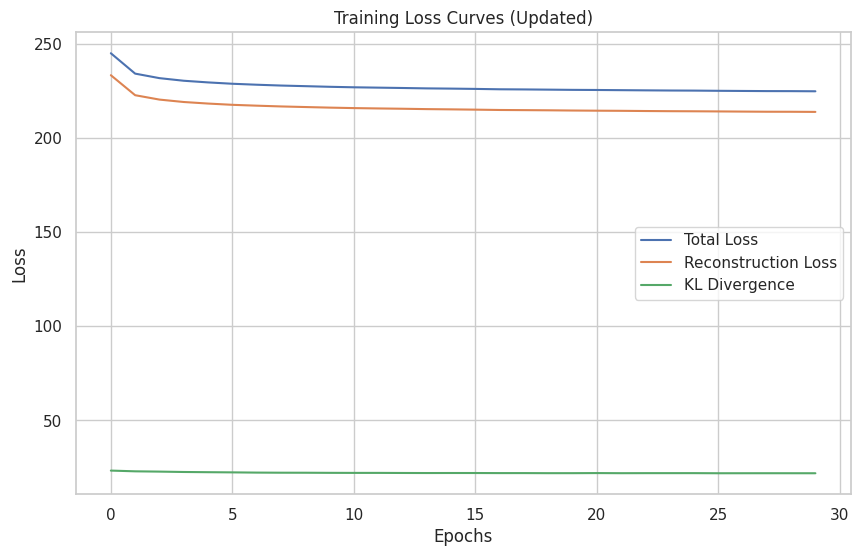

In [ ]:
# Load losses from the .pkl file
latent_dim = checkpoint['params']['latent_dim']
learning_rate = checkpoint['params']['learning_rate']
beta = checkpoint['params']['beta']
file_name = f'training_results_ld_{latent_dim}_lr_{learning_rate}_beta_{beta}.pkl'

with open(file_name, 'rb') as f:
    results = pickle.load(f)

# Initialize lists with previous losses from the .pkl file
reconstruction_losses = results['reconstruction_losses']
kl_divergence_losses = results['kl_losses']
total_losses = results['total_losses']

# Hyperparameters
new_epochs = 25  # Number of additional epochs to train
starting_epoch = checkpoint['params']['epochs']  # Retrieve the starting epoch from the checkpoint
total_epochs = starting_epoch + new_epochs

# Training loop
for epoch in range(starting_epoch + 1, total_epochs + 1):
    cvae.train()
    running_recon_loss = 0.0
    running_kl_loss = 0.0
    running_total_loss = 0.0

    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)
        # Convert labels to one-hot encoding for conditional input
        c = F.one_hot(labels, num_classes=condition_dim).float()
        optimizer.zero_grad()

        # Forward pass
        recon_batch, mu, logvar = cvae(data, c)
        loss, recon_loss, kl_loss = loss_function_cvae(recon_batch, data, mu, logvar, beta)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate losses
        running_recon_loss += recon_loss.item()
        running_kl_loss += kl_loss.item()
        running_total_loss += loss.item()

    epoch_recon_loss = running_recon_loss / len(train_loader.dataset)
    epoch_kl_loss = running_kl_loss / len(train_loader.dataset)
    epoch_total_loss = running_total_loss / len(train_loader.dataset)

    reconstruction_losses.append(epoch_recon_loss)
    kl_divergence_losses.append(epoch_kl_loss)
    total_losses.append(epoch_total_loss)

    print(f"Epoch {epoch}, Loss: {epoch_total_loss:.4f}, Recon: {epoch_recon_loss:.4f}, KL: {epoch_kl_loss:.4f}")

# Save updated losses back to the .pkl file
results['reconstruction_losses'] = reconstruction_losses
results['kl_losses'] = kl_divergence_losses
results['total_losses'] = total_losses

file_name = f'training_results_ld_{latent_dim}_lr_{learning_rate}_beta_{beta}_full.pkl'

with open(file_name, 'wb') as f:
    pickle.dump(results, f)

# Plot updated training loss curves
plt.figure(figsize=(10, 6))
plt.plot(total_losses, label="Total Loss")
plt.plot(reconstruction_losses, label="Reconstruction Loss")
plt.plot(kl_divergence_losses, label="KL Divergence")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curves (Updated)')
plt.legend()
plt.show()

In [ ]:
torch.save(cvae.state_dict(), f'cvae.pth')

# **4. Visulization the results**

## **4.1. Visualization reconstruced images**

Using the function provided from the course we can now plot the results.

In [ ]:
import matplotlib.pyplot as plt

def image_comparison(original_images, reconstructions, n_images=6):
    """Plots the original images and its reconstructions for comparison

    Args:
        original_image (torch.Tensor): The original images
        reconstructions (torch.Tensor): Reconstruction of the original images
    """
    fig, ax = plt.subplots(2, n_images, figsize=(10, 5))

    for i in range(n_images):
        # Plot original images
        ax[0, i].imshow(original_images[i], cmap='gray')
        ax[0, i].axis('off')
        ax[0, 0].set_title('Original')

        # Reconstructed images
        ax[1, i].imshow(reconstructions[i], cmap='gray')
        ax[1, i].axis('off')
        ax[1, 0].set_title('Recomstruction')

    plt.tight_layout()
    plt.show()

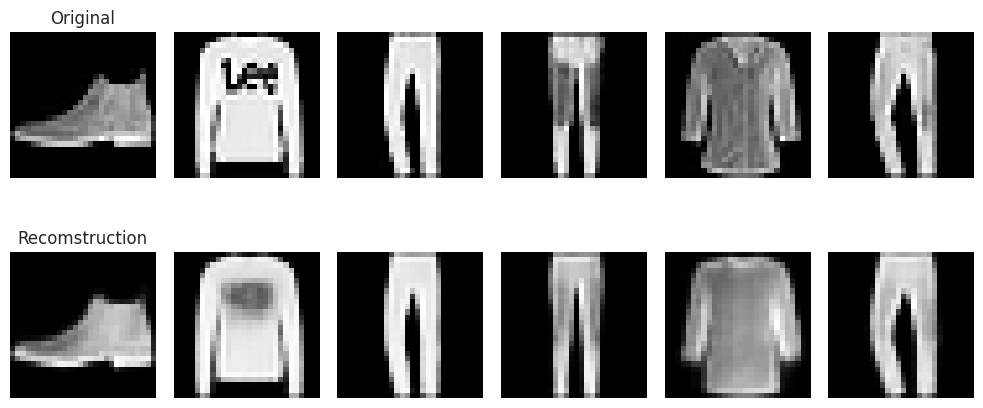

In [ ]:
random_images, labels = next(iter(test_loader))

c = F.one_hot(labels, num_classes=condition_dim).float().to(device)  # Convert labels to one-hot encoding

recons, _, _ = cvae(random_images.to(device), c)  # Get the reconstructions of the selected images

random_images = random_images.cpu().numpy().squeeze()
recons = recons.detach().cpu().numpy().squeeze()

# Plot the original images and their reconstructions
image_comparison(random_images, recons)

## **4.2. Visualization generated images**

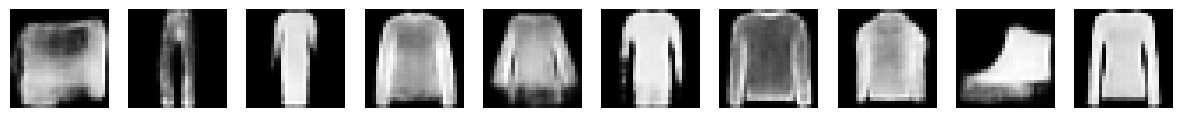

In [ ]:
def generate_sample(num_samples=10):
    cvae.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)  # Sample random latent vectors

        random_labels = torch.randint(0, condition_dim, (num_samples,)).to(device)  # Random class labels
        c = F.one_hot(random_labels, num_classes=condition_dim).float().to(device)  # One-hot encode labels

        samples = cvae.decode(z,c) # Decode the latent vectors
        samples = samples.cpu().view(num_samples, 1, 28, 28) # Reshape the samples

        fig, ax = plt.subplots(1, num_samples, figsize=(15, 2))
        for i in range(num_samples):
            ax[i].imshow(samples[i].squeeze(0), cmap='gray')
            ax[i].axis('off')
        plt.show()

generate_sample()

Unlike a normal VAE, the CVAE allows us to generate samples from specific classes. In this case, we will plot five generated samples from each class by sampling from the latent space and decoding the images.

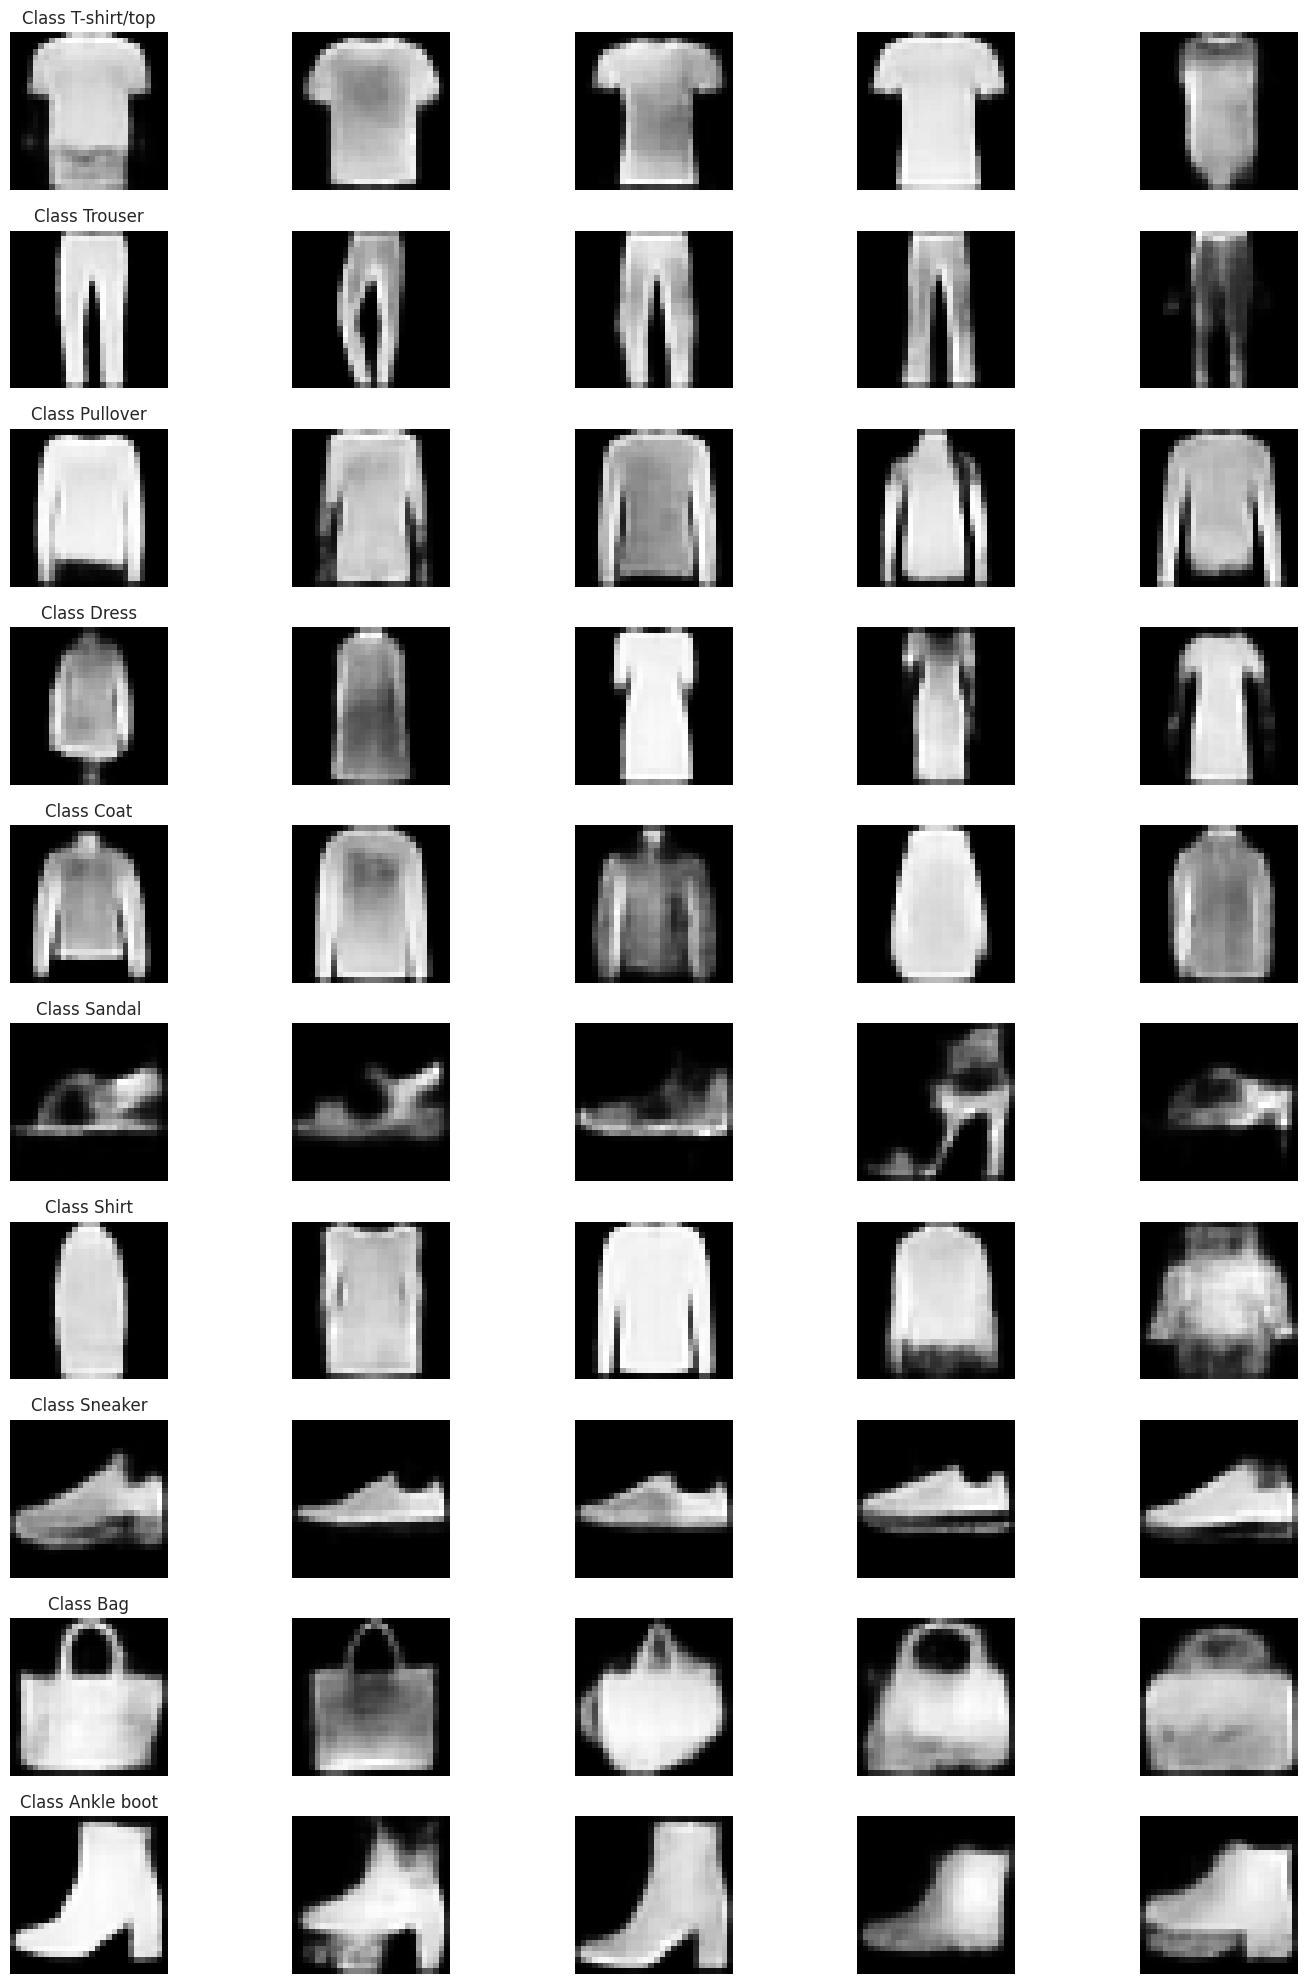

In [ ]:
def generate_sample_per_class(num_samples_per_class=5):
    cvae.eval()
    with torch.no_grad():
        fig, ax = plt.subplots(condition_dim, num_samples_per_class, figsize=(15, 2 * condition_dim))

        for class_idx in range(condition_dim):
            z = torch.randn(num_samples_per_class, latent_dim).to(device)  # Sample random latent vectors
            c = F.one_hot(torch.full((num_samples_per_class,), class_idx), num_classes=condition_dim).float().to(device)  # One-hot encode class label

            samples = cvae.decode(z, c)  # Decode the latent vectors
            samples = samples.cpu().view(num_samples_per_class, 1, 28, 28)  # Reshape the samples

            for i in range(num_samples_per_class):
                ax[class_idx, i].imshow(samples[i].squeeze(0), cmap='gray')
                ax[class_idx, i].axis('off')
                ax[class_idx, i].set_title(f'Class {class_names[class_idx]}' if i == 0 else "")

        plt.tight_layout()
        plt.show()

# Call the function to generate samples
generate_sample_per_class(num_samples_per_class=5)


We can see that the model is able to generate new samples from each class. Just like the original images, these images are blurry, but we can distinguish the groups.

On the other hand, we can see that some of the clothing classes might be close in the latent space. For example, we can see that some of the t-shirt examples could also look like dresses due to a long "torso."

Let's now visualize the latent space to better understand the model and the impact of the beta term (KL weight).

## **4.3. Visualizing the latent space**

In [ ]:
def plot_latent_space_pca(model, test_dataset, condition_dim, kl_weight):
    model.eval()
    with torch.no_grad():
        # Load the entire test dataset
        test_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset), shuffle=False)
        data, labels = next(iter(test_loader))
        data, labels = data.to(device), labels.to(device)
        c = F.one_hot(labels, num_classes=condition_dim).float()

        # Get the latent variables (mean values of latent distribution)
        mu, logvar = model.encode(data, c)
        z = mu.cpu().numpy()
        labels = labels.cpu().numpy()

        # Apply PCA to reduce latent dimensions to 2
        pca = PCA(n_components=2)
        z_2d = pca.fit_transform(z)

        # Plot the PCA-reduced latent space
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
        plt.colorbar(scatter, ticks=range(condition_dim))
        plt.title(f'Latent Space (PCA) with KL Weight = {kl_weight}')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.show()

In [ ]:
def train_and_plot_pca(kl_weight, test_dataset, train_loader, val_loader):
    model = CVAE(latent_dims, condition_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_model = None
    lowest_val_loss = float('inf')
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        epoch_loss, bce_loss, kld_loss = 0, 0, 0
        model.train()

        # Training phase
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            c = F.one_hot(labels, num_classes=condition_dim).float()

            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data, c)
            loss, bce, kld = loss_function_cvae(recon_batch, data, mu, logvar, kl_weight)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            bce_loss += bce.item()
            kld_loss += kld.item()

        avg_train_loss = epoch_loss / len(train_loader.dataset)
        avg_train_bce = bce_loss / len(train_loader.dataset)
        avg_train_kld = kld_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss, val_bce_loss, val_kld_loss = 0, 0, 0
        with torch.no_grad():
            for data, labels in val_loader:
                data, labels = data.to(device), labels.to(device)
                c = F.one_hot(labels, num_classes=condition_dim).float()

                recon_batch, mu, logvar = model(data, c)
                loss, bce, kld = loss_function_cvae(recon_batch, data, mu, logvar, kl_weight)

                val_loss += loss.item()
                val_bce_loss += bce.item()
                val_kld_loss += kld.item()

        avg_val_loss = val_loss / len(val_loader.dataset)
        avg_val_bce = val_bce_loss / len(val_loader.dataset)
        avg_val_kld = val_kld_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)

        # Save the best model based on validation loss
        if avg_val_loss < lowest_val_loss:
            lowest_val_loss = avg_val_loss
            best_model = {
                'model_state_dict': model.state_dict(),
                'kl_weight': kl_weight,
                'latent_dims': latent_dims,
                'condition_dim': condition_dim,
            }

        print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, '
              f'Train BCE: {avg_train_bce:.4f}, Train KLD: {avg_train_kld:.4f} | '
              f'Val Loss: {avg_val_loss:.4f}, Val BCE: {avg_val_bce:.4f}, Val KLD: {avg_val_kld:.4f}')

    # Save the best model to disk
    if best_model is not None:
        torch.save(best_model, f'best_model_kl_{kl_weight}.pth')

    # Plot latent space using the best model
    best_model_state = torch.load(f'best_model_kl_{kl_weight}.pth')
    model.load_state_dict(best_model_state['model_state_dict'])
    plot_latent_space_pca(model, test_dataset, condition_dim, kl_weight)


Training CVAE with KL Weight = 1
Epoch 1: Train Loss: 254.6942, Train BCE: 240.1686, Train KLD: 14.5256 | Val Loss: 246.4341, Val BCE: 231.6801, Val KLD: 14.7540
Epoch 2: Train Loss: 243.5615, Train BCE: 229.5280, Train KLD: 14.0336 | Val Loss: 242.9568, Val BCE: 229.4735, Val KLD: 13.4833
Epoch 3: Train Loss: 241.0109, Train BCE: 227.1760, Train KLD: 13.8350 | Val Loss: 241.2210, Val BCE: 228.1748, Val KLD: 13.0462
Epoch 4: Train Loss: 239.4745, Train BCE: 225.7039, Train KLD: 13.7706 | Val Loss: 240.2039, Val BCE: 226.8803, Val KLD: 13.3236
Epoch 5: Train Loss: 238.5609, Train BCE: 224.7821, Train KLD: 13.7788 | Val Loss: 239.5606, Val BCE: 225.9070, Val KLD: 13.6535
Epoch 6: Train Loss: 237.8470, Train BCE: 224.1004, Train KLD: 13.7466 | Val Loss: 239.0353, Val BCE: 225.2117, Val KLD: 13.8236
Epoch 7: Train Loss: 237.2197, Train BCE: 223.4971, Train KLD: 13.7227 | Val Loss: 239.1414, Val BCE: 225.8125, Val KLD: 13.3289
Epoch 8: Train Loss: 236.7983, Train BCE: 223.0805, Train KLD: 

<ipython-input-47-90c6935150a8>:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model_state = torch.load(f'best_model_kl_{kl_weight}.pth')


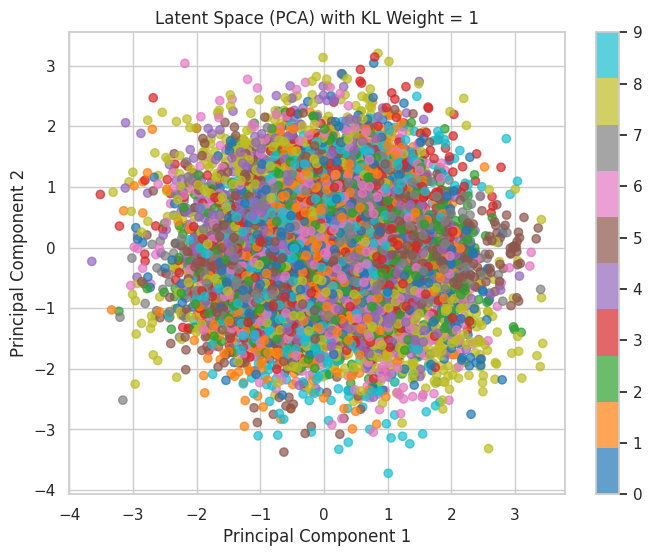


Training CVAE with KL Weight = 10
Epoch 1: Train Loss: 296.1253, Train BCE: 279.0501, Train KLD: 1.7075 | Val Loss: 287.1197, Val BCE: 268.5392, Val KLD: 1.8580
Epoch 2: Train Loss: 283.8336, Train BCE: 265.9412, Train KLD: 1.7892 | Val Loss: 283.8665, Val BCE: 265.5541, Val KLD: 1.8312
Epoch 3: Train Loss: 281.7222, Train BCE: 263.0951, Train KLD: 1.8627 | Val Loss: 282.9151, Val BCE: 262.7979, Val KLD: 2.0117
Epoch 4: Train Loss: 280.4091, Train BCE: 261.6231, Train KLD: 1.8786 | Val Loss: 281.7677, Val BCE: 263.6274, Val KLD: 1.8140
Epoch 5: Train Loss: 279.5180, Train BCE: 260.4683, Train KLD: 1.9050 | Val Loss: 281.1189, Val BCE: 262.4320, Val KLD: 1.8687
Epoch 6: Train Loss: 278.9909, Train BCE: 259.7553, Train KLD: 1.9236 | Val Loss: 281.0021, Val BCE: 261.8978, Val KLD: 1.9104
Epoch 7: Train Loss: 278.7008, Train BCE: 259.1894, Train KLD: 1.9511 | Val Loss: 280.3856, Val BCE: 260.8557, Val KLD: 1.9530
Epoch 8: Train Loss: 278.3364, Train BCE: 258.7821, Train KLD: 1.9554 | Val 

<ipython-input-47-90c6935150a8>:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model_state = torch.load(f'best_model_kl_{kl_weight}.pth')


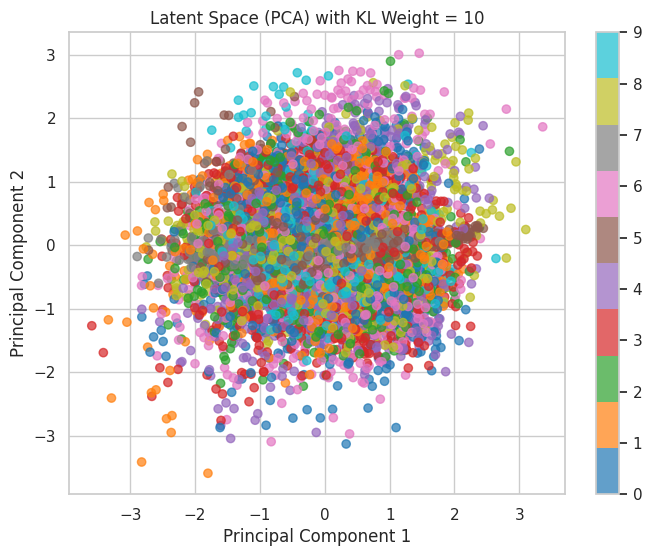


Training CVAE with KL Weight = 100
Epoch 1: Train Loss: 316.4929, Train BCE: 313.1898, Train KLD: 0.0330 | Val Loss: 312.7343, Val BCE: 311.9261, Val KLD: 0.0081
Epoch 2: Train Loss: 308.5467, Train BCE: 308.2611, Train KLD: 0.0029 | Val Loss: 311.4596, Val BCE: 311.3514, Val KLD: 0.0011
Epoch 3: Train Loss: 307.9292, Train BCE: 307.8372, Train KLD: 0.0009 | Val Loss: 310.7713, Val BCE: 310.7016, Val KLD: 0.0007
Epoch 4: Train Loss: 307.6678, Train BCE: 307.6018, Train KLD: 0.0007 | Val Loss: 310.7925, Val BCE: 310.7208, Val KLD: 0.0007
Epoch 5: Train Loss: 307.4770, Train BCE: 307.4199, Train KLD: 0.0006 | Val Loss: 310.9354, Val BCE: 310.8548, Val KLD: 0.0008
Epoch 6: Train Loss: 307.3997, Train BCE: 307.3581, Train KLD: 0.0004 | Val Loss: 311.1178, Val BCE: 311.0667, Val KLD: 0.0005
Epoch 7: Train Loss: 307.3171, Train BCE: 307.2747, Train KLD: 0.0004 | Val Loss: 311.1956, Val BCE: 311.1279, Val KLD: 0.0007
Epoch 8: Train Loss: 307.2347, Train BCE: 307.2007, Train KLD: 0.0003 | Val

<ipython-input-47-90c6935150a8>:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model_state = torch.load(f'best_model_kl_{kl_weight}.pth')


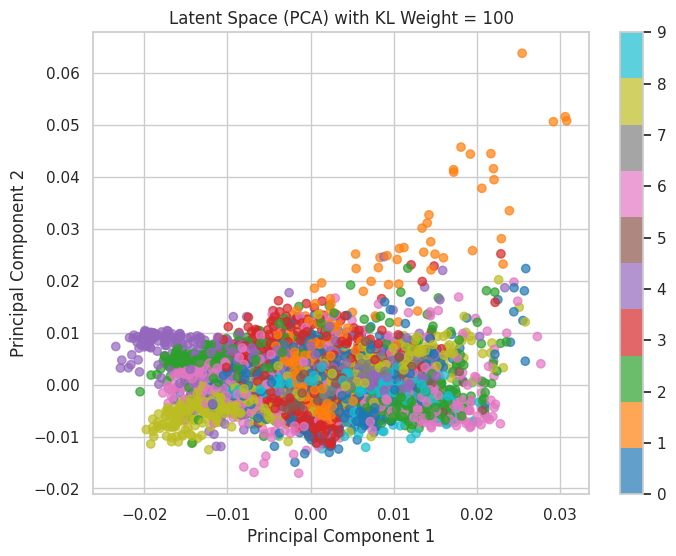

In [ ]:
# Hyperparameters
latent_dims = 20
condition_dim = 10 ###
batch_size = 128
num_epochs = 30
learning_rate = 1e-3
kl_weights = [1, 10, 100]  # Different weights for the KL divergence term

for kl_weight in kl_weights:
    print(f'\nTraining CVAE with KL Weight = {kl_weight}')
    train_and_plot_pca(kl_weight, test_dataset, train_loader, val_loader)

### Comments on the latent space representation
When we look at the latent representations for KL weight = 1, we can see that the classes aren't well separated. This indicates that the model is focusing more on getting the reconstruction right, but not necessarily on organizing the latent space in a way that clearly distinguishes between different classes. The model might be overfitting to the reconstruction task, without enough emphasis on learning a structured latent space.


However, when we increase KL weight to 10 and 100, we see much better class separation. This happens because the model is putting more weight on the KL divergence term, which helps it learn a more structured latent space. As a result, the model is encouraged to group similar classes together in the latent space, making the representation more organized and interpretable.


That said, when KL weight becomes too large, like 100, we might start to see some downsides. The latent space might become too regularized, meaning the model simplifies things too much, which could hurt the reconstruction quality and make the model less flexible in capturing finer details. So, while increasing KL weight improves class separation, it's important to find the right balance.

# **5. Evaluation the generation images**

In [ ]:
# Function to generate images from VAE
def generate_images(model, num_images, latent_dim):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_images, latent_dim).to(device)
        c = torch.randint(0, 10, (num_images,)).to(device)
        c = F.one_hot(c, num_classes=10).float()
        generated = model.decode(z, c)
        generated = torch.sigmoid(generated)  # Ensure pixel values are in [0, 1]
    return generated

# Preprocess images for Inception
def preprocess_images(images, batch_size=256):
    # Process images in smaller batches
    processed_images = []
    for i in range(0, len(images), batch_size):
        batch = images[i:i+batch_size]
        batch = F.interpolate(batch, size=(299, 299), mode='bilinear', align_corners=False)
        batch = batch.repeat(1, 3, 1, 1)  # Convert to 3 channels
        processed_images.append(batch)
    return torch.cat(processed_images)

# Calculate Inception Score
def calculate_inception_score(images, inception_model, splits=10):
    images = preprocess_images(images).to(device)
    with torch.no_grad():
        preds = inception_model(images).softmax(dim=1).cpu().numpy()
    scores = []
    for i in range(splits):
        part = preds[i * (len(preds) // splits):(i + 1) * (len(preds) // splits)]
        kl_div = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, 0), 0)))
        kl_div = np.mean(np.sum(kl_div, axis=1))
        scores.append(np.exp(kl_div))
    return np.mean(scores), np.std(scores)

# Calculate FID
def calculate_fid(real_images, generated_images, inception_model):
    real_images = preprocess_images(real_images).to(device)
    generated_images = preprocess_images(generated_images).to(device)

    with torch.no_grad():
        real_features = inception_model(real_images).detach().cpu().numpy()
        generated_features = inception_model(generated_images).detach().cpu().numpy()

    # Calculate mean and covariance
    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = generated_features.mean(axis=0), np.cov(generated_features, rowvar=False)

    # Calculate FID
    diff = mu1 - mu2
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

# Evaluate IS and FID
def evaluate_is_fid(model, test_loader, num_generated_images=10000, batch_size=256):
    # Load pre-trained Inception v3
    inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
    inception_model.eval()

    # Generate synthetic images in batches
    generated_images = []
    for _ in range(0, num_generated_images, batch_size):
        batch = generate_images(model, batch_size, latent_dims)
        generated_images.append(batch.cpu())
    generated_images = torch.cat(generated_images)[:num_generated_images]

    # Collect real images from test_loader in batches
    real_images = []
    for data, _ in test_loader:
        real_images.append(data)
        if len(real_images) * data.size(0) >= num_generated_images:
            break
    real_images = torch.cat(real_images)[:num_generated_images]

    # Preprocess real and generated images in smaller batches
    real_images = preprocess_images(real_images, batch_size=batch_size)
    generated_images = preprocess_images(generated_images, batch_size=batch_size)

    # Calculate IS
    is_mean, is_std = calculate_inception_score(generated_images, inception_model, splits=10)

    # Calculate FID
    fid = calculate_fid(real_images, generated_images, inception_model)

    print(f"Inception Score: {is_mean:.4f} ± {is_std:.4f}")
    print(f"FID: {fid:.4f}")
    return is_mean, is_std, fid

# Example usage
is_mean, is_std, fid = evaluate_is_fid(cvae, test_loader, num_generated_images=10000)


NameError: name 'cvae' is not defined

In [ ]:
torch.cuda.empty_cache()

# Sources:

Kihyuk Sohn, Xinchen Yan and Honglak Lee(2015). Learning Structured Output Representation using Deep Conditional Generative Models. Retrieved from https://proceedings.neurips.cc/paper_files/paper/2015/file/8d55a249e6baa5c06772297520da2051-Paper.pdf

Pyro.ai. (n.d.). Conditional Variational Autoencoder (CVAE). Retrieved from https://pyro.ai/examples/cvae.html

Beckham, R. (2023, April 27). Conditional Variational Autoencoders (CVAE). Retrieved from https://beckham.nz/2023/04/27/conditional-vaes.html

Shiksha.com. (n.d.). ReLU and Sigmoid Activation Functions. Retrieved from https://www.shiksha.com/online-courses/articles/relu-and-sigmoid-activation-function/#ReLU

Zalando Research. (n.d.). Fashion MNIST: A Dataset for Fashion Recognition. Retrieved from https://github.com/zalandoresearch/fashion-mnist
